In [1]:
from tms_risk.utils.data import get_all_behavior
import seaborn as sns
import pingouin
import matplotlib.pyplot as plt
import os.path as op
import pandas as pd
import numpy as np
from tms_risk.cogmodels.fit_probit import build_model, get_data
import arviz as az
from tms_risk.cogmodels.utils import stimulation_palette, stimulation_order
from tms_risk.cogmodels.utils import extract_intercept_gamma, format_bambi_ppc, plot_ppc

bids_folder = '/data/ds-tmsrisk'


sns.set(style='white', font='helvetica', font_scale=1.6)

In [2]:
import scipy.stats as ss
model_label = 'probit_average_n_full'

In [3]:
data = get_data(model_label, bids_folder)
model = build_model(model_label, data)
idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))


intercept, gamma = extract_intercept_gamma(idata, model, data, group=True)
intercept = intercept.stack([1, 2])['intercept']
gamma = gamma.stack([1, 2])['gamma']

rnp = np.clip(np.exp(intercept/gamma),0, 1).rename('rnp')

rnp = rnp.to_frame()
gamma = gamma.to_frame()


rnp.set_index(pd.Series(rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'}), name='Order'), append=True, inplace=True)
gamma.set_index(pd.Series(gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'}), name='Order'), append=True, inplace=True)

rnp =rnp.reset_index('Order')
rnp['Order'] = pd.Categorical(rnp['Order'].map({'Risky first':'Risky first', 'Safe first':'Risky second'}), ordered=True)
rnp.set_index('Order', append=True, inplace=True)

gamma = gamma.reset_index('Order')
gamma['Order'] = pd.Categorical(gamma['Order'].map({'Risky first':'Risky first', 'Safe first':'Risky second'}), ordered=True)
gamma.set_index('Order', append=True, inplace=True)

Dropping the baseline condition


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25012/3206736077.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  intercept = intercept.stack([1, 2])['intercept']
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25012/3206736077.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  gamma = gamma.stack([1, 2])['gamma']


/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)


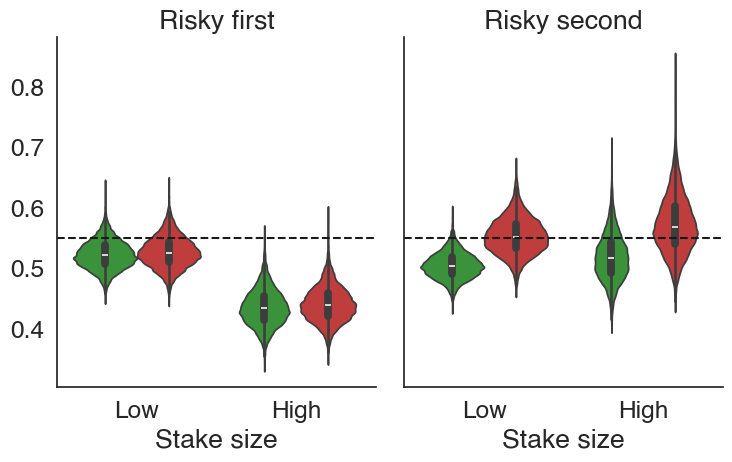

In [34]:
g = sns.catplot(x='average_n_bin', y='rnp', col='Order', data=rnp.reset_index(), kind='violin', hue='stimulation_condition', palette=stimulation_palette, aspect=.8, legend=False)

g.map(plt.axhline, y=0.55, color='k', linestyle='--')

g.set(xticklabels=['Low', 'High'], xlabel='Stake size', ylabel=None, )

# g.axes[0][0].annotate('Risk seeking', xy=(0.01, 0.54), xycoords='axes fraction', ha='left', fontsize=12)
# g.axes[0][0].annotate('Risk Aversion', xy=(0.01, 0.15), xycoords='axes fraction', ha='left', fontsize=12)

g.set_titles('{col_name}')

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'stake_effect_rnp.pdf'))


/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)


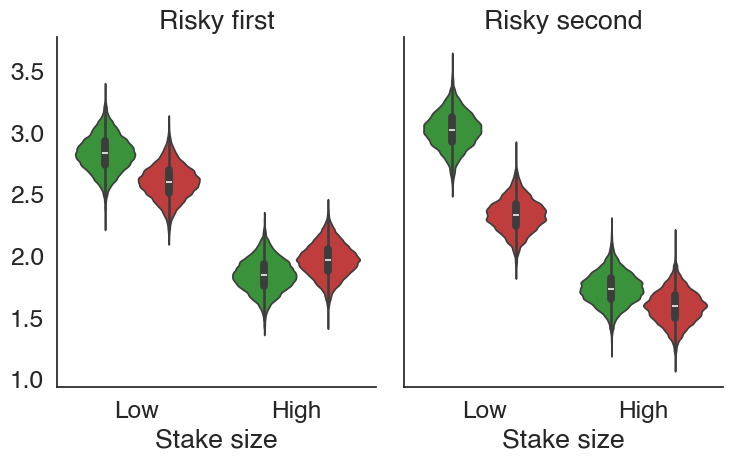

In [35]:
g = sns.catplot(x='average_n_bin', y='gamma', col='Order', data=gamma.reset_index(), kind='violin', hue='stimulation_condition', palette=stimulation_palette, aspect=.8, legend=False)

# g.map(plt.axhline, y=0.55, color='k', linestyle='--')

g.set(xticklabels=['Low', 'High'], xlabel='Stake size', ylabel=None, )

g.set_titles('{col_name}')

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'stake_effect_gamma.pdf'))

/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)


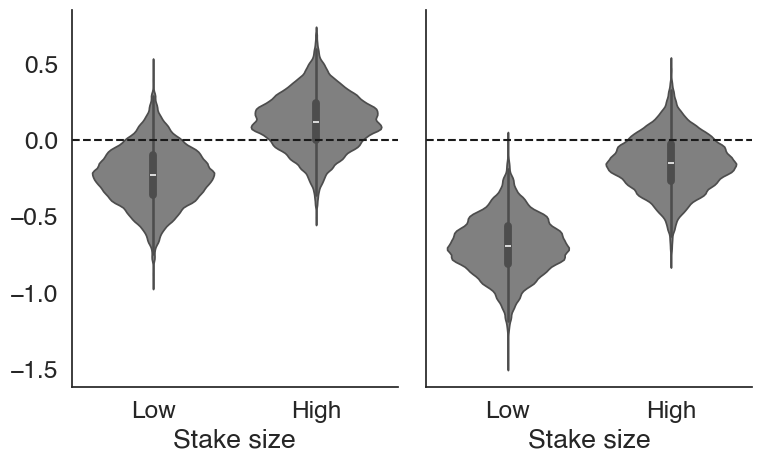

In [43]:
gamma_diff = gamma.unstack('stimulation_condition')['gamma']
gamma_diff['diff'] = gamma_diff['ips'] - gamma_diff['vertex']
gamma_diff = gamma_diff['diff']

g = sns.catplot(x='average_n_bin', y='diff', col='Order', data=gamma_diff.reset_index(), kind='violin', aspect=.8, legend=False, color='gray')

g.set(xticklabels=['Low', 'High'], xlabel='Stake size', ylabel=None, )
g.set_titles('')

g.map(plt.axhline, y=0, color='k', linestyle='--')

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'stake_effect_gamma_diff.pdf'))

In [39]:
gamma_diff.groupby(['Order', 'average_n_bin']).apply(lambda x: (x>0.0).mean())

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25012/3031021504.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gamma_diff.groupby(['Order', 'average_n_bin']).apply(lambda x: (x>0.0).mean())


Order         average_n_bin
Risky first   low              0.111000
              high             0.752125
Risky second  low              0.000250
              high             0.204000
Name: diff, dtype: float64

/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)
/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(**kwargs)


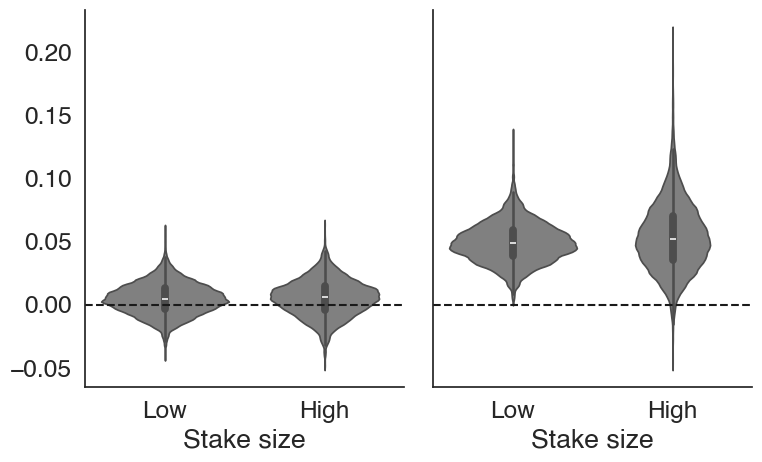

In [42]:
rnp_diff = rnp.unstack('stimulation_condition')['rnp']
rnp_diff['diff'] = rnp_diff['ips'] - rnp_diff['vertex']
rnp_diff = rnp_diff['diff']

g = sns.catplot(x='average_n_bin', y='diff', col='Order', data=rnp_diff.reset_index(), kind='violin', aspect=.8, legend=False, color='gray')

g.set(xticklabels=['Low', 'High'], xlabel='Stake size', ylabel=None, )
g.set_titles('')

g.map(plt.axhline, y=0, color='k', linestyle='--')

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'stake_effect_rnp_diff.pdf'))

In [41]:
rnp_diff.groupby(['Order', 'average_n_bin']).apply(lambda x: (x<0.0).mean())

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25012/4150032163.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rnp_diff.groupby(['Order', 'average_n_bin']).apply(lambda x: (x<0.0).mean())


Order         average_n_bin
Risky first   low              0.353875
              high             0.342750
Risky second  low              0.000000
              high             0.011750
Name: diff, dtype: float64

In [45]:
ppc = format_bambi_ppc(idata, model, data)

In [47]:
from tms_risk.cogmodels.utils import summarize_ppc

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25012/3794129756.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppc_stats =ppc.loc['p'].groupby(['subject', 'risky_first', 'bin(risky/safe)', 'stimulation_condition', 'average_n_bin']).mean().groupby(['risky_first', 'bin(risky/safe)', 'stimulation_condition', 'average_n_bin']).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25012/3794129756.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppc_stats =ppc.loc['p'].groupby(['subject', 'risky_first', 'bin(risky/safe)', 'stimulation_condition', 'average_n_bin']).mean().groupby(['r

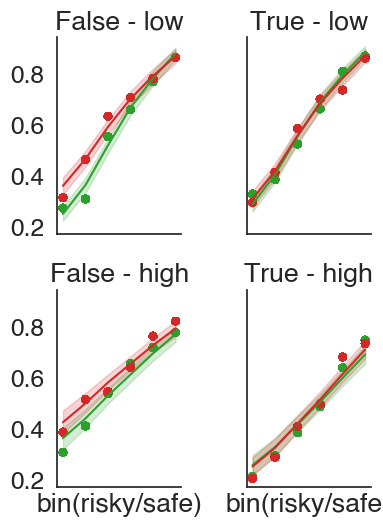

In [106]:
ppc_stats =ppc.loc['p'].groupby(['subject', 'risky_first', 'bin(risky/safe)', 'stimulation_condition', 'average_n_bin']).mean().groupby(['risky_first', 'bin(risky/safe)', 'stimulation_condition', 'average_n_bin']).mean()


# g = sns.FacetGrid(ppc_stats.reset_index(), col='risky_first', row='bin(risky/safe)', hue='stimulation_condition', palette=stimulation_palette, aspect=1.5)

# g.map(sns.lineplot, 'bin(risky/safe)' 


ppc_stats = ppc_stats.stack(level=[0,1]).to_frame("p_predicted")
ppc_stats = ppc_stats.join(data.groupby(['risky_first', 'average_n_bin', 'stimulation_condition', 'bin(risky/safe)', ])['chose_risky'].mean())

# sns.lineplot(ppc_stats.reset_index(), x='bin(risky/safe)', y='p_predicted', hue='stimulation_condition', palette=stimulation_palette)

g = sns.FacetGrid(ppc_stats.reset_index(), row='average_n_bin', col='risky_first', hue='stimulation_condition', palette=stimulation_palette, aspect=.8,
                  hue_order=['vertex', 'ips'])


g.map(sns.lineplot, 'bin(risky/safe)', 'p_predicted', errorbar=lambda x: az.hdi(x.values, hdi_prob=0.95))

g.map(sns.scatterplot, 'bin(risky/safe)', 'chose_risky', edgecolor='none')

g.set_titles('{col_name} - {row_name}')

g.set(xticks=[], ylabel=None)

In [70]:
data

rt    n1    n2  \
subject session stimulation_condition run trial_nr                         
1       2       vertex                1   1         1.239692  28.0  86.0   
                                          2         0.836219   7.0  21.0   
                                          3         0.931371   7.0  21.0   
                                          4         1.135164  10.0  24.0   
                                          5         1.032161  20.0  44.0   
...                                                      ...   ...   ...   
74      3       vertex                6   116       1.055890  37.0  20.0   
                                          117       0.739095  55.0  14.0   
                                          118       0.371731  22.0  20.0   
                                          119       0.705755  14.0  10.0   
                                          120       0.672241  15.0  14.0   

                                                      p1    p2  choice  \
subject session stimulation_condition run trial_nr                       
1       2       vertex                1   1         1.00  0.55     2.0   
                                          2         1.00  0.55     2.0   
                                          3         1.00  0.55     2.0   
                                          4         1.00  0.55     1.0   
                                          5         1.00  0.55     1.0   
...                                                  ...   ...     ...   
74      3       vertex                6   116       0.55  1.00     2.0   
                                          117       0.55  1.00     2.0   
                                          118       0.55  1.00     2.0   
                                          119       0.55  1.00     2.0   
                                          120       0.55  1.00     2.0   

                                                    risky_first  chose_risky  \
subject session stimulation_condition run trial_nr                             
1       2       vertex                1   1               False         True   
                                          2               False         True   
                                          3               False         True   
                                          4               False        False   
                                          5               False        False   
...                                                         ...          ...   
74      3       vertex                6   116              True        False   
                                          117              True        False   
                                          118              True        False   
                                          119              True        False   
                                          120              True        False   

                                                    n_risky  n_safe      frac  \
subject session stimulation_condition run trial_nr                              
1       2       vertex                1   1            86.0    28.0  3.071429   
                                          2            21.0     7.0  3.000000   
                                          3            21.0     7.0  3.000000   
                                          4            24.0    10.0  2.400000   
                                          5            44.0    20.0  2.200000   
...                                                     ...     ...       ...   
74      3       vertex                6   116          37.0    20.0  1.850000   
                                          117          55.0    14.0  3.928571   
                                          118          22.0    20.0  1.100000   
                                          119          14.0    10.0  1.400000   
                                          120          15.0    14.0  1.071429   

           

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25012/2585626569.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['risky_first', 'average_n_bin', 'stimulation_condition'])['chose_risky'].mean()


risky_first  average_n_bin  stimulation_condition
False        low            ips                      0.587302
                            vertex                   0.523721
             high           ips                      0.645320
                            vertex                   0.604720
True         low            ips                      0.556279
                            vertex                   0.550235
             high           ips                      0.509881
                            vertex                   0.501493
Name: chose_risky, dtype: float64

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25012/1802672806.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppc_stats.join(data.groupby(['risky_first', 'average_n_bin', 'stimulation_condition'])['chose_risky'].mean())


p_predicted  \
risky_first bin(risky/safe) stimulation_condition chain draw average_n_bin                
False       20%             ips                   0     0    low               0.388697   
                                                             high              0.388697   
                                                        1    low               0.403025   
                                                             high              0.403025   
                                                        2    low               0.374786   
...                                                                                 ...   
True        80%             vertex                3     1997 high              0.738257   
                                                        1998 low               0.787373   
                                                             high              0.787373   
                                                        1999 low               0.764000   
                                                             high              0.764000   

                                                                            chose_risky  
risky_first bin(risky/safe) stimulation_condition chain draw average_n_bin               
False       20%             ips                   0     0    low               0.587302  
                                                             high              0.645320  
                                                        1    low               0.587302  
                                                             high              0.645320  
                                                        2    low               0.587302  
...                                                                                 ...  
True        80%             vertex                3     1997 high              0.501493  
                                                        1998 low               0.550235  
                                                             high              0.501493  
                                                        1999 low               0.550235  
                                                             high              0.501493  

[384000 rows x 2 columns]

In [62]:
ppc_stats

p_predicted
risky_first bin(risky/safe) stimulation_condition chain draw             
False       20%             ips                   0     0        0.388697
                                                        1        0.403025
                                                        2        0.374786
                                                        3        0.381793
                                                        4        0.376981
...                                                                   ...
True        80%             vertex                3     1995     0.782538
                                                        1996     0.764149
                                                        1997     0.738257
                                                        1998     0.787373
                                                        1999     0.764000

[192000 rows x 1 columns]

In [ ]:
ppc.loc['p'].stack().stack()

chain                                                                                                                                                                                                                                                     0  \
draw                                                                                                                                                                                                                                                   0      
variable     subject session stimulation_condition run trial_nr rt       n1   n2   p1   p2   choice risky_first chose_risky n_risky n_safe frac     log(risky/safe) log(n1)  bin(risky/safe) x        session3 log_n_safe average_n average_n_bin             
ll_bernoulli 1       2       vertex                1   1        1.239692 28.0 86.0 1.00 0.55 2.0    False       True        86.0    28.0   3.071429 1.122143        3.332205 80%             1.122143 0        3.332205   57.0      high           1.000000   
                                                       2        0.836219 7.0  21.0 1.00 0.55 2.0    False       True        21.0    7.0    3.000000 1.098612        1.945910 80%             1.098612 0        1.945910   14.0      low            1.000000   
                                                       3        0.931371 7.0  21.0 1.00 0.55 2.0    False       True        21.0    7.0    3.000000 1.098612        1.945910 80%             1.098612 0        1.945910   14.0      low            1.000000   
                                                       4        1.135164 10.0 24.0 1.00 0.55 1.0    False       False       24.0    10.0   2.400000 0.875469        2.302585 44%             0.875469 0        2.302585   17.0      low            0.000000   
                                                       5        1.032161 20.0 44.0 1.00 0.55 1.0    False       False       44.0    20.0   2.200000 0.788457        2.995732 44%             0.788457 0        2.995732   32.0      high           1.000000   
...                                                                                                                                                                                                                                                     ...   
p            74      3       vertex                6   116      1.055890 37.0 20.0 0.55 1.00 2.0    True        False       37.0    20.0   1.850000 0.615186        3.610918 44%             0.615186 1        2.995732   28.5      high           0.093087   
                                                       117      0.739095 55.0 14.0 0.55 1.00 2.0    True        False       55.0    14.0   3.928571 1.368276        4.007333 80%             1.368276 1        2.639057   34.5      high           0.552735   
                                                       118      0.371731 22.0 20.0 0.55 1.00 2.0    True        False       22.0    20.0   1.100000 0.095310        3.091042 20%             0.095310 1        2.995732   21.0      low            0.004616   
                                                       119      0.705755 14.0 10.0 0.55 1.00 2.0    True        False       14.0    10.0   1.400000 0.336472        2.639057 32%             0.336472 1        2.302585   12.0      low            0.029171   
                                                       120      0.672241 15.0 14.0 0.55 1.00 2.0    True        False       15.0    14.0   1.071429 0.068993        2.708050 20%             0.068993 1        2.639057   14.5      low            0.003671   

chain                                                                                                                                                                                                                                                        \
draw                                                                                                                                                                          